In [1]:
import numpy as np
import pandas as pd
from data.bioinformatics import run_bioinformatics
from data.visualization import process_logo, plot_logo
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import os
import random
from itertools import combinations
from collections import Counter

import matplotlib as mpl

font = {'family' : 'sans-serif',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

#functions for calculating diversity
def hamming_distance(seq1, seq2):
    """Compute Hamming distance between two sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def pairwise_diversity(sequences):
    """Calculate average pairwise Hamming distance for a list of sequences."""
    seq_list = list(sequences)  # Ensure it's a list
    pairs = list(combinations(seq_list, 2))  # Generate all sequence pairs
    distances = [hamming_distance(a, b) for a, b in pairs]
    return sum(distances) / len(distances) if distances else 0  # Avoid division by zero

def shannon_entropy(sequences):
    """Compute Shannon entropy over a set of aligned sequences."""
    length = len(sequences.iloc[0])  # Assume all sequences are same length
    entropy = []
    
    for i in range(length):
        column = [seq[i] for seq in sequences]
        freqs = np.array(list(Counter(column).values())) / len(column)
        entropy.append(-np.sum(freqs * np.log2(freqs)))  # Shannon entropy formula

    return np.mean(entropy)  # Average entropy over all positions

# Perplexity of generated sequences
evaluated in the finetuned ProGen2 Models

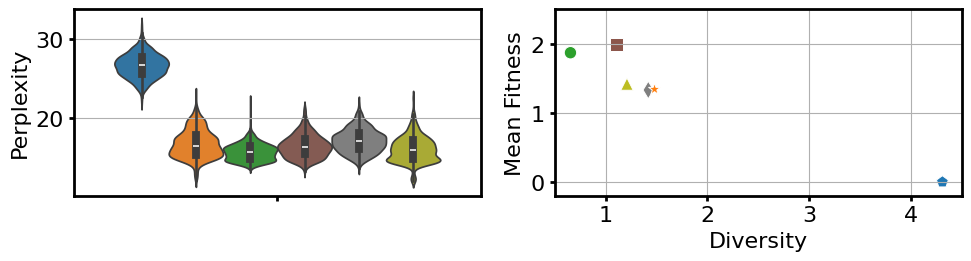

In [21]:
proteins = ["GB1"] #["TrpB", "CreiLOV"]
# models = ["random", "continuous", "d3pm", "d3pm_finetune", "causalLM_finetune"] 
tasks = ["unconstrained"] #"constrained"
sites = [117, 118, 119, 162, 166, 182, 183, 184, 185, 186, 227, 228, 230, 231, 301]
diversity_metric = shannon_entropy
# order = ["random", "target", "continuous", "continuous_ESM", "d3pm", "d3pm_finetune", "udlm", "mdlm", "causalLM_finetune"] 
#map the order to versions with the first letter capitalized
#order = ["Random", "Target", "Continuous", "Continuous-ESM", "D3PM-Baseline", "D3PM", "UDLM", "MDLM", "ARLM"]
order = ["Random", "Target", "Continuous", "D3PM", "MDLM", "ARLM"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:brown", "tab:gray", "tab:olive"]
i =0
i =0
plt.figure(figsize=(10, 5))
for protein in proteins:
    df = pd.read_csv(f'exps/protein/perplexity/{protein}/perplexity.csv')
    for task in tasks:
        i += 1
        plt.subplot(2, 2, i)
        subset_df = df[df['task'] == task]
        #rename the prior column based on a mapping
    
        subset_df["prior"] = subset_df["prior"].map({
            "random": "Random",
            "target": "Target",
            "continuous": "Continuous",
            "continuous_ESM": "Continuous-ESM",
            "d3pm": "D3PM-Baseline",
            "d3pm_finetune": "D3PM",
            "udlm": "UDLM",
            "mdlm": "MDLM",
            "causalLM_finetune": "ARLM"
        })
        
        #sns.violinplot(data=subset_df, x='finetuned', y='perplexity', hue="prior", legend=legend)
        sns.violinplot(data=subset_df, y='perplexity', hue="prior", legend=False, hue_order=order, palette=colors)
        plt.grid(axis='y')
        plt.ylabel("Perplexity")
        # plt.title(f'{protein}')

        i += 1
        legend = True if i == 4 else False
        plt.subplot(2, 2, i)

        if protein == "TrpB":
            #take only the positions that are in the sites list
            subset_df["sequence"] = subset_df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))
            # #round of negative fitness values to 0
            # subset_df["fitness"] = subset_df["fitness"].apply(lambda x: max(0, x))

        # df = df.groupby(["guidance_param", "task", "repeat"]).agg({"fitness": "mean", "sequence": shannon_entropy}).reset_index() #nunique
        #groupby and return the number of unique sequences
        subset_df = subset_df.groupby("prior").agg({"fitness": "mean", "sequence": diversity_metric}).reset_index()
        #rename sequence to diversity
        subset_df = subset_df.rename(columns={"sequence": "diversity"})
        subset_df["category"] = subset_df["prior"].map({
            "Random": "Pentagon",
            "Target": "Star",
            "Continuous": "Circle",
            "Continuous-ESM": "Circle",
            "D3PM": "Square",
            "D3PM-Baseline": "Square",
            "UDLM": "Square",
            "MDLM": "Diamond",
            "ARLM": "Triangle"
        })
        #use the same order as the original dataframe
        sns.scatterplot(data=subset_df, x="diversity", y="fitness", hue="prior", s=80, hue_order=order, style="category", markers=['p', "*", 'o', 's', 'd', '^'], style_order=["Pentagon", "Star", "Circle", "Square", "Diamond", "Triangle"], palette=colors , legend=False)
        plt.xlim(0.5, 4.5)
        if protein == "TrpB":
            plt.ylim(-0.05, 0.45)
            plt.xlabel("")
            #remove xtick_labels
            plt.gca().set_xticklabels([])
        elif protein == "CreiLOV":
            plt.ylim(1.5, 4.5)
            plt.xlabel("Diversity")
        elif protein == "GB1":
            plt.ylim(-0.2, 2.5)
            plt.xlim(0.5, 4.5)
            plt.xlabel("Diversity")
        plt.grid()
        plt.ylabel("Mean Fitness")
        
        #plt.title(f'{protein}')
#legend off to the side
#plt.legend(loc='center left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"figures/perplexity.svg")

In [2]:
def fill_sequence(sequences, protein, full_seq):
    """
    Aligns sequences to a reference and fills in gaps with the reference sequence.
    """
    #save to fasta
    #if sequences is a string of the fasta file name
    if type(sequences) == str:
        os.system(f"mafft --quiet --add {sequences} --keeplength data/{protein}.fasta > tmp/aligned.fasta")
    else:
        with open(f"temp.fasta", "w") as f:
            for i, seq in enumerate(sequences):
                f.write(f">{i}\n")
                f.write(f"{seq}\n")
        os.system(f"mafft --quiet --add temp.fasta --keeplength data/{protein}.fasta > tmp/aligned.fasta")

    aligned = list(SeqIO.parse("tmp/aligned.fasta", "fasta"))

    return aligned

aa_options = "ACDEFGHIKLMNPQRSTVWY"

def replace_gaps(aligned, full_seq):
    #replace gaps with the parent sequence
    for i, seq in enumerate(aligned):
        for j, r in enumerate(seq):
            if r == "-":
                #sample a random residue from aa_options
                # random_res = random.choice(aa_options)
                # aligned[i] = aligned[i][:j] + random_res + aligned[i][j+1:]
                aligned[i] = aligned[i][:j] + full_seq[j] + aligned[i][j+1:] #alteratively fill with WT
    return aligned

def drop_gapped(aligned, sites):
    #drop sequences with gaps
    #take only the positions in sites
    combos = ["".join([seq[j] for j in sites]) for seq in aligned]
    aligned = [seq for seq, combo in zip(aligned, combos) if "-" not in combo]
    print(len(aligned))
    return aligned

def get_mutations(variant, full_seq):
    #return the position and the mutation
    return [str(i+1) + variant[i] for i in range(len(variant)) if variant[i] != full_seq[i]]
    
def get_n_mutations(variant, full_seq):
    return sum([1 for i in range(len(variant)) if variant[i] != full_seq[i]])

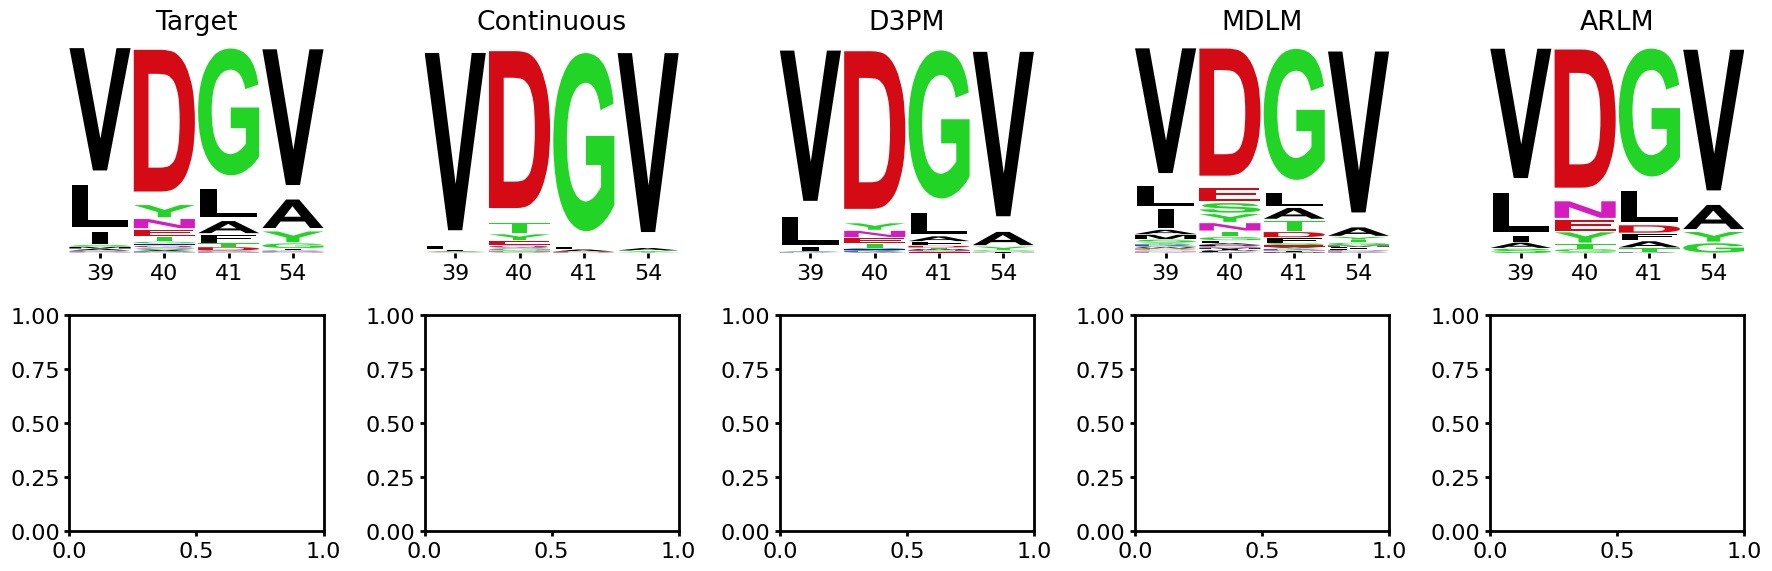

In [ ]:
#priors = ["target",  "continuous", "continuous_ESM", "d3pm", "d3pm_finetune", "udlm", "mdlm", "causalLM_finetune"]
priors = ["target",  "continuous", "d3pm_finetune", "mdlm", "causalLM_finetune"]
order = ["Target", "Continuous", "D3PM", "MDLM", "ARLM"]

fig, axs = plt.subplots(2,len(priors),figsize=[18, 6])

for i, protein in enumerate(["GB1"]): #, "CreiLOV" #["TrpB", "CreiLOV"]
    if 'TrpB' in protein:
        sites = [183, 184, 227, 228]
        full_seq = "MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLRDYAGRPTPLYFARRLSEKYGARVYLKREDLLHTGAHKINNAIGQVLLAKLMGKTRIIAETGAGQHGVATATAAALFGMECVIYMGEEDTIRQKLNVERMKLLGAKVVPVKSGSRTLKDAIDEALRDWITNLQTTYYVFGSVVGPHPYPIIVRNFQKVIGEETKKQIPEKEGRLPDYIVACVSGGSNAAGIFYPFIDSGVKLIGVEAGGEGLETGKHAASLLKGKIGYLHGSKTFVLQDDWGQVQVSHSVSAGLDYSGVGPEHAYWRETGKVLYDAVTDEEALDAFIELSRLEGIIPALESSHALAYLKKINIKGKVVVVNLSGRGDKDLESVLNHPYVRERIR"
    elif protein == 'CreiLOV':
        full_seq = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
        sites = [29, 34, 47, 60, 61] #7, 29, 47 have multiple types of beneficial mutations whereas 5 and 60 have two choice but high fitness
        #sites = None
    elif protein == "GB1":
        full_seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
        sites = [39, 40, 41, 54]
    for j, (model, name) in enumerate(zip(priors, order)): #"causalLM_finetune",
        ax = axs[i,j]
        if model == "target":
            results_df = pd.read_csv(f"data/{protein}/MSA.csv")
        elif model == "reference2":
            #reference for other stuff
            sequences = SeqIO.parse(f'data/{protein}/reference_aligned.fasta', format='fasta')
            sequences = [str(seq.seq) for seq in sequences]

            sequences = replace_gaps(sequences, full_seq)
            #sequences = drop_gapped(sequences, sites)
            results_df = pd.DataFrame({'sequence': sequences})
        elif model == "causalLM_finetune":
            sequences = SeqIO.parse(f'exps/protein/{protein}/{model}/prior_sample/unconstrained/generated.fasta', format='fasta') #uncond
            # sequences = fill_sequence(sequences, protein, full_seq)
            # sequences = replace_gaps(sequences, full_seq)

            #1equences = drop_gapped(sequences, sites) 

            results_df = pd.DataFrame({'sequence': sequences})
        else:
            sequences = SeqIO.parse(f'exps/protein/{protein}/{model}/prior_sample/unconstrained/generated.fasta', format='fasta') #uncond
            sequences = [str(seq.seq) for seq in sequences]
            results_df = pd.DataFrame({'sequence': sequences})
            #sequences = f'exps/protein/{protein}/{model}/default/uncond/generated.fasta'
            #results_df = run_bioinformatics(seqs_or_fasta=sequences, ref_db='data/ref_databases/swissprot')
        logo_df = process_logo(results_df, sites=sites)

        name = name if i == 0 else ""
        logo_plot = plot_logo(logo_df, name=name, ax=ax,sites=sites)

plt.tight_layout()
#plt.savefig(f"figures/logos.svg")

### Hamming Distances

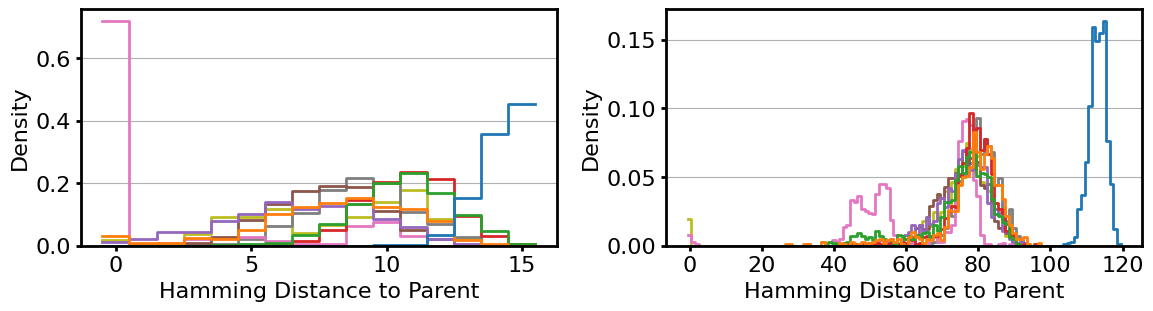

In [21]:
#get the hamming distance of the sequence to parent
proteins = ["TrpB", "CreiLOV"]
models = ["random", "target",  "continuous", "continuous_ESM", "d3pm", "d3pm_finetune", "udlm", "mdlm", "causalLM_finetune"]
order = ["Random", "Target", "Continuous", "Continuous-ESM", "D3PM-Baseline", "D3PM", "UDLM", "MDLM", "ARLM"]
tasks = ["unconstrained"]

i =0
plt.figure(figsize=(12, 6))
for protein in proteins:
    if protein == "CreiLOV":
        parent = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
    else:
        parent = "MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLRDYAGRPTPLYFARRLSEKYGARVYLKREDLLHTGAHKINNAIGQVLLAKLMGKTRIIAETGAGQHGVATATAAALFGMECVIYMGEEDTIRQKLNVERMKLLGAKVVPVKSGSRTLKDAIDEALRDWITNLQTTYYVFGSVVGPHPYPIIVRNFQKVIGEETKKQIPEKEGRLPDYIVACVSGGSNAAGIFYPFIDSGVKLIGVEAGGEGLETGKHAASLLKGKIGYLHGSKTFVLQDDWGQVQVSHSVSAGLDYSGVGPEHAYWRETGKVLYDAVTDEEALDAFIELSRLEGIIPALESSHALAYLKKINIKGKVVVVNLSGRGDKDLESVLNHPYVRERIR"
    df = pd.read_csv(f'exps/protein/perplexity/{protein}/perplexity.csv')
    for task in tasks:
        i += 1
        plt.subplot(2, 2, i)
        subset_df = df[df['task'] == task]
        #subset_df = subset_df[subset_df['finetuned'] == True]
        legend = True if i == 2 else False
        subset_df["hamming_distance"] = subset_df.apply(lambda x: hamming_distance(x["sequence"], parent), axis=1)
        subset_df["prior"] = subset_df["prior"].map({
           "random": "Random",
           "target": "Target",    
            "continuous": "Continuous",
            "continuous_ESM": "Continuous-ESM",
            "d3pm": "D3PM-Baseline",
            "d3pm_finetune": "D3PM",
            "udlm": "UDLM",
            "mdlm": "MDLM",
            "causalLM_finetune": "ARLM"
        })
        #sns.violinplot(data=subset_df, y='hamming_distance', hue="prior", legend=legend, cut=0)
        #histogram with step and not filled in
        sns.histplot(data=subset_df, x='hamming_distance', hue="prior", legend=False, stat="density", common_norm=False, fill=False, element="step", discrete=True, hue_order=order)
        #sns.countplot(data=subset_df, x='hamming_distance', hue="prior", legend=legend)
        plt.grid(axis='y')
        #plt.title(f'{protein} {task}')
        plt.xlabel("Hamming Distance to Parent")
        #legend off to the side
        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f"figures/hamming_distance.svg")


Examine hamming distance for the variants with ideal fitness

In [ ]:
df = pd.read_csv("exps/protein/TrpB/d3pm_finetune/iterative_BO/cls_guidance/BO_summary.csv")
parent = "MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLRDYAGRPTPLYFARRLSEKYGARVYLKREDLLHTGAHKINNAIGQVLLAKLMGKTRIIAETGAGQHGVATATAAALFGMECVIYMGEEDTIRQKLNVERMKLLGAKVVPVKSGSRTLKDAIDEALRDWITNLQTTYYVFGSVVGPHPYPIIVRNFQKVIGEETKKQIPEKEGRLPDYIVACVSGGSNAAGIFYPFIDSGVKLIGVEAGGEGLETGKHAASLLKGKIGYLHGSKTFVLQDDWGQVQVSHSVSAGLDYSGVGPEHAYWRETGKVLYDAVTDEEALDAFIELSRLEGIIPALESSHALAYLKKINIKGKVVVVNLSGRGDKDLESVLNHPYVRERIR"
df["hamming_distance"] = df.apply(lambda x: hamming_distance(x["sequence"], parent), axis=1)
df.sort_values(by=["fitness"], inplace=True, ascending=False)

df = df.head(50`)
mean_hamming_distance = df["hamming_distance"].mean()
print(f"Mean Hamming Distance: {mean_hamming_distance}")
df

Mean Hamming Distance for CreiLOV: 6.52


,sequence,round,fitness,guidance_param,repeat,task,hamming_distance
2137,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,3,1.593834,0.064,2,unconstrained,6
377,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,3,1.582759,0.064,0,unconstrained,5
850,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,8,1.582515,0.064,0,unconstrained,5
2178,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,3,1.559094,0.064,2,unconstrained,7
571,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,5,1.557398,0.064,0,unconstrained,5
3973,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,3,1.511879,0.064,4,unconstrained,5
1627,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,7,1.506915,0.064,1,unconstrained,7
4353,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,7,1.504733,0.064,4,unconstrained,6
4218,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,6,1.499274,0.064,4,unconstrained,6
583,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,5,1.495309,0.064,0,unconstrained,7


In [28]:
df = pd.read_csv("exps/protein/CreiLOV/d3pm_finetune/iterative_BO/cls_guidance/BO_summary.csv")
parent = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
df["hamming_distance"] = df.apply(lambda x: hamming_distance(x["sequence"], parent), axis=1)
df.sort_values(by=["fitness"], inplace=True, ascending=False)

#take mean hamming distance for the top 50
df = df.head(50)
mean_hamming_distance = df["hamming_distance"].mean()
print(f"Mean Hamming Distance for {protein}: {mean_hamming_distance}")
df

Mean Hamming Distance for CreiLOV: 66.06


,sequence,round,fitness,guidance_param,repeat,task,hamming_distance
2258,MAGLRHTFVVADATLPDCPLIDCNHGFYAMTGYDRGEVIGRNPKML...,4,5.332521,0.064,2,unconstrained,65
1701,MAGLRHTFVVADATVDDYTVIEVNPTFCQITGYSKKEILGKNAKFL...,8,5.301777,0.064,1,unconstrained,70
4381,MAGLSSTFVITDATNEQCNIIYVNDAFQQMTGYQLAEIVGRNARIL...,7,5.299455,0.064,4,unconstrained,70
552,MAGLRHTCVVCDATMEECPLVYINPAFEELTGYTEAEAIGRNPRWL...,5,5.289496,0.064,0,unconstrained,65
420,MAGLRKSLVVTDATLPDCPLIYANDGFLEMTGYQREEVVGKNARFL...,4,5.271163,0.064,0,unconstrained,55
1251,MAGLRHTFVVADATDRDLRIIWVNDGFLGLSGYGEEEVLGKNPSFL...,3,5.266678,0.064,1,unconstrained,68
419,MAISRKDVVVADATDEDFPIIYCNPGFTDLSGYKLEEVVNRSPRFL...,4,5.264296,0.064,0,unconstrained,66
4110,MAGLRHALVVADATLPDCPFVYTNRAFTQMTGYDKRQVIGKNPRLL...,5,5.261660,0.064,4,unconstrained,64
4177,MAGLRHTFVVADATLPDCPIVYVNPAFCRLTGYTKAEVIGRSPRIL...,5,5.257527,0.064,4,unconstrained,70
3381,MAILRHAIVLTDPNLPDFPFVYASDGFYQLTGYSRDEMLGRNRSFL...,6,5.253715,0.064,3,unconstrained,70


## Pareto curves showing tradeoff between fitness and diversity

In [10]:
#df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/TrpB/continuous/pareto/NOS/pareto_summary.csv")
# df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/TrpB/mdlm_small/pareto/NOS/pareto_summary.csv")

# df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/CreiLOV/continuous/pareto/cls_guidance/pareto_summary.csv")
#df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/CreiLOV/continuous/pareto/NOS/pareto_summary.csv")
# df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/CreiLOV/mdlm_small/pareto/NOS/pareto_summary.csv")
#df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/TrpB/mdlm/pareto/DAPS/pareto_summary.csv")
# df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/CreiLOV/d3pm_finetune/pareto/DAPS/pareto_summary.csv")

#df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/TrpB/d3pm_finetune/pareto/cls_guidance/pareto_summary.csv")
df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/TrpB/causalLM_finetune/pareto/DPO/pareto_summary.csv")

diversity_metric =  shannon_entropy #shannon_entropy #"nunique"

#for TrpB 
sites = [117, 118, 119, 162, 166, 182, 183, 184, 185, 186, 227, 228, 230, 231, 301]
df["sequence"] = df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))

df = df.groupby(["guidance_param", "round"]).agg({"fitness": "mean", "sequence": diversity_metric}).reset_index()
#rename sequence to diversity
df = df.rename(columns={"sequence": "diversity"})
df

,guidance_param,round,fitness,diversity
0,0.00,0,0.161520,2.253017
1,0.25,1,0.153254,2.251041
2,0.50,1,0.162428,2.228836
3,1.00,1,0.182947,2.181820
4,2.00,1,0.456234,1.828203
5,4.00,1,0.085425,2.301394


In [26]:
df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/CreiLOV/continuous/pareto/DAPS/pareto_summary.csv")
diversity_metric = shannon_entropy #"nunique"

# sites = [117, 118, 119, 162, 166, 182, 183, 184, 185, 186, 227, 228, 230, 231, 301]
# df["sequence"] = df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))

df = df.groupby(["guidance_param", "round"]).agg({"fitness": "mean", "sequence": diversity_metric}).reset_index()
#rename sequence to diversity
df = df.rename(columns={"sequence": "diversity"})
df

,guidance_param,round,fitness,diversity
0,0.0,0,3.968923,2.562613
1,2500.0,1,3.951997,2.304617
2,5000.0,1,3.991066,2.278705
3,10000.0,1,4.066813,2.200958
4,20000.0,1,4.245757,2.031665
5,40000.0,1,4.568458,1.694494


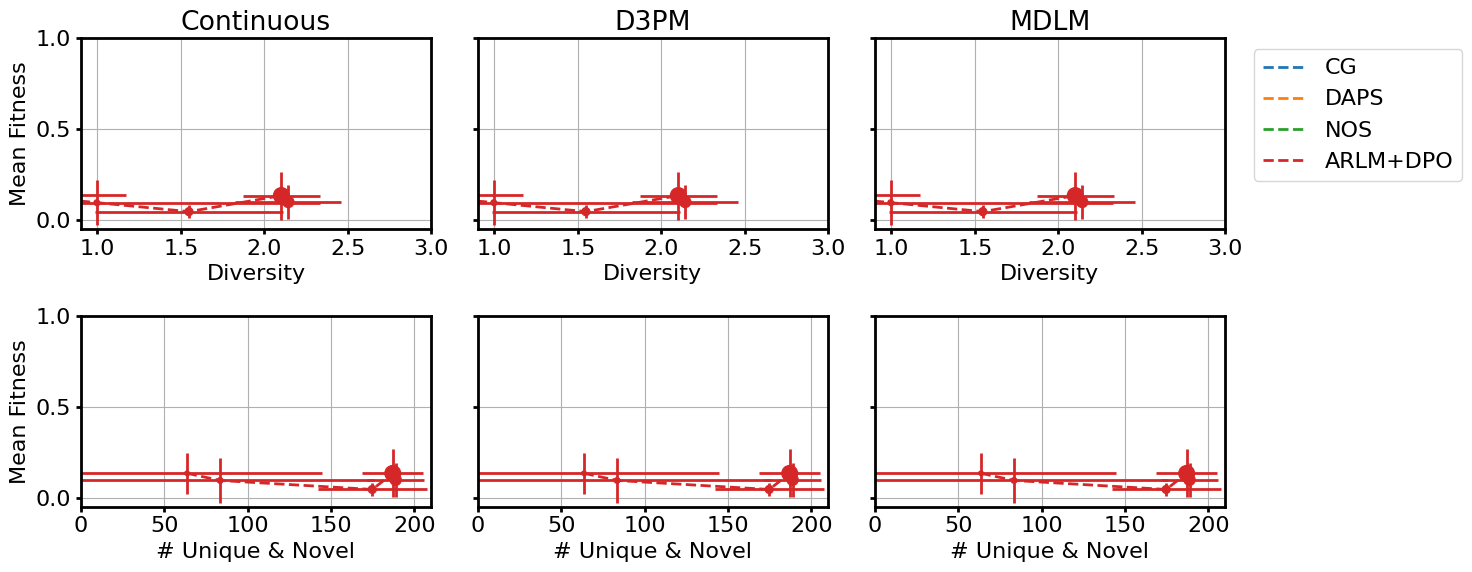

In [3]:
models = ["continuous", "d3pm_finetune", "mdlm"] #"continuous" #"d3pm_finetune", "d3pm_finetune", "causalLM_finetune"
model_names = ["Continuous", "D3PM", "MDLM"]
methods = ["cls_guidance", "DAPS", "NOS", "ARLM+DPO"] #"random", #"cls_guidance", "DAPS", "DPO"
method_names = ["CG", "DAPS", "NOS", "ARLM+DPO"] #"Random" #, "DPO"

colors = sns.color_palette("tab10", n_colors=len(methods))
#proteins = ["GB1"] #["TrpB", "CreiLOV"] # "CreiLOV" "TrpB"
sites = [117, 118, 119, 162, 166, 182, 183, 184, 185, 186, 227, 228, 230, 231, 301]
diversity_metrics = [shannon_entropy, "nunique"] #"nunique"  #shannon_entropy #"nunique"
task = "unconstrained"

plt.figure(figsize=(15, 6))
protein = "TrpB"

for i, diversity_metric in enumerate(diversity_metrics):
    for j, (model, model_name) in enumerate(zip(models, model_names)):
        plt.subplot(len(diversity_metrics), len(models), i*len(models) + j + 1)
       
        for method, method_name, color in zip(methods, method_names, colors):
            flag = False

            if method != "random":
                if method == "ARLM+DPO":
                    try:
                        df = pd.read_csv(f"exps/protein/{protein}/causalLM_finetune/pareto/DPO/pareto_summary.csv")
                    except:
                        continue
                else:
                    try:
                        path = f"exps/protein/{protein}/{model}/pareto/{method}/pareto_summary.csv"
                        df = pd.read_csv(path)
                        print("Loaded data for ", path)
                    except:
                        plt.plot(0, 0, "--", color=color, label=f"{method_name}")
                        continue
                
                round0_df = df[df["round"] == 0]
                df = df[df["round"] == 1]

                #group by ["guidance_param", "task", "repeat"], taking the mean of "fitness" and the unique counts in "sequence"
                if protein == "TrpB":
                    #take only the positions that are in the sites list
                    df["sequence"] = df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))
                    #round of negative fitness values to 0
                    # df["fitness"] = df["fitness"].apply(lambda x: max(0, x))

                if diversity_metric == "nunique":
                    #drop if sequence and repeat are the same as something from round0
                    #calculates sequences that are unique and novel
                    df = df[~df[["sequence", "repeat"]].apply(tuple, 1).isin(round0_df[["sequence", "repeat"]].apply(tuple, 1))]
                
                df = df.groupby(["guidance_param", "task", "repeat"]).agg({"fitness": "mean", "sequence": diversity_metric}).reset_index()
                df = df.rename(columns={"sequence": "diversity"})
                

                subset_df = df[df["task"] == task]

                # Compute aggregated statistics for fitness and diversity
                grouped = subset_df.groupby("guidance_param")[["fitness", "diversity"]].agg(["mean", "std"]).reset_index()
                #grouped = df.groupby("guidance_param")["fitness", "diversity"].agg(["mean", "std"]).reset_index()


                # if model == "continuous":
                #     sizes = np.log10(grouped["guidance_param"])*40
                # elif model == "d3pm_finetune" and method == "cls_guidance":
                #     sizes = -np.log10(grouped["guidance_param"])*40
                # elif method == "DAPS":
                #     sizes = (np.log10(grouped["guidance_param"]) + 2)*40
                # elif method == "DPO":
                #     sizes = (np.log10(grouped["guidance_param"]) + 2)*40

                grouped = grouped.sort_values(by=("diversity", "mean"))

                #get the order of the guidance_param
                ascending = True if (method == "NOS") or (model == "continuous" and method == "cls_guidance") or (method == "DAPS") or (method == "ARLM+DPO")  else False #
                #ascending = False

                order = grouped.sort_values(by=("diversity", "mean"), ascending=ascending).index.values
                sizes = [8, 16, 32, 64, 128]
                sizes = sizes[:len(order)]
                #reorder the sizes
                #print(order)
                sizes = [sizes[i] for i in order]

                # Plot mean with dots and no lines
                #sort from low to high diversity value mean subset
                
                plt.plot(grouped["diversity"]["mean"], grouped["fitness"]["mean"], color=color, linestyle="--", label=f"{method_name}")

                # Add error bars on x and y axis
                plt.errorbar(grouped["diversity"]["mean"], grouped["fitness"]["mean"], xerr=grouped["diversity"]["std"], yerr=grouped["fitness"]["std"], fmt='.', color=color, elinewidth=2)

                #make the size of the dot proportional to the guidance parameter value
                plt.scatter(grouped["diversity"]["mean"], grouped["fitness"]["mean"], s=sizes, color=color)
            else:
                random_df = pd.read_csv(f"exps/protein/{protein}/baseline/summary.csv")
                random_df = random_df[random_df["method"] == "random"]
                random_df = random_df[random_df["task"] == task]
                
                if protein == "TrpB":
                    #take only the positions that are in the sites list
                    random_df["sequence"] = random_df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))
                
                plt.plot(shannon_entropy(random_df["sequence"]), random_df["fitness"].mean(), "p", markersize=8, label="Random", color=color)
        
        #plot unconditional sampling as a reference
        try:
            #df = pd.read_csv(f"exps/protein/{protein}/{model}/pareto/cls_guidance/pareto_summary.csv")
            df = pd.read_csv(f"exps/protein/{protein}/{model}/prior_sample/summary.csv")

            round0_df = df
            #round0_df = df[df["round"] == 0]

            #group by ["guidance_param", "task", "repeat"], taking the mean of "fitness" and the unique counts in "sequence"
            if protein == "TrpB":
                #take only the positions that are in the sites list
                round0_df["sequence"] = round0_df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))
                #round of negative fitness values to 0
                # df["fitness"] = df["fitness"].apply(lambda x: max(0, x))

            round0_df = round0_df.groupby(["task", "repeat"]).agg({"fitness": "mean", "sequence": diversity_metric}).reset_index()
            round0_df = round0_df.rename(columns={"sequence": "diversity"})
            grouped0 = round0_df.groupby("task")[["fitness", "diversity"]].agg(["mean", "std"]).reset_index()

            plt.errorbar(grouped0["diversity"]["mean"], grouped0["fitness"]["mean"], xerr=grouped0["diversity"]["std"], yerr=grouped0["fitness"]["std"], fmt='s', color='tab:purple', markersize=8, elinewidth=2, label="Unconditional")
            
        except:
            pass

        plt.ylabel("Mean Fitness")

        if j != 0:
            plt.ylabel("")
            plt.gca().set_yticklabels([])

        if diversity_metric == "nunique":  
            plt.xlim(0, 210)
            plt.xlabel("# Unique & Novel")
        else:
            plt.xlabel("Diversity")
            if protein == "TrpB" or protein == "CreiLOV":
                plt.xlim(0.9, 3.0)
            else:
                plt.xlim(0, 2.2)
                # plt.ylim(1.6,  5.5)
                # plt.xlim(0, 4.5)
        
        if i == 0:
            plt.title(f"{model_name}")
            #plt.gca().set_xticklabels([])
            #plt.xlabel("")
        
        if protein == "TrpB":
            plt.ylim(-0.05, 1.0)
        elif protein == "CreiLOV":
            plt.ylim(3.2,  5.2)
        
        if i*3 + j + 1 == 3:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()

plt.tight_layout()
plt.savefig(f"figures/pareto.svg")

### Hyperparameter scan for NOS

In [21]:
df = pd.read_csv(f"exps/protein/TrpB/continuous/prior_sample/summary.csv")

round0_df = df
#round0_df = df[df["round"] == 0]

#group by ["guidance_param", "task", "repeat"], taking the mean of "fitness" and the unique counts in "sequence"
if protein == "TrpB":
    #take only the positions that are in the sites list
    round0_df["sequence"] = round0_df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))
    #round of negative fitness values to 0
    # df["fitness"] = df["fitness"].apply(lambda x: max(0, x))

round0_df = round0_df.groupby(["task", "repeat"]).agg({"fitness": "mean", "sequence": diversity_metric}).reset_index()
round0_df = round0_df.rename(columns={"sequence": "diversity"})
grouped0 = round0_df.groupby("task")[["fitness", "diversity"]].agg(["mean", "std"]).reset_index()

FileNotFoundError: [Errno 2] No such file or directory: 'exps/protein/TrpB/continuous/prior_sample/summary.csv'

In [24]:
df = pd.read_csv("/disk1/jyang4/repos/guided-discrete-diffusion/exps/protein/TrpB/d3pm_finetune/pareto/cls_guidance/pareto_summary.csv")
df.groupby(["round", "repeat", "guidance_param", "task"]).count()

sequence  fitness
round repeat guidance_param task                            
0     0      0.0000         constrained          20       20
                            unconstrained        20       20
      1      0.0000         constrained          20       20
                            unconstrained        20       20
1     0      0.0001         constrained          20       20
                            unconstrained        20       20
             0.0010         constrained          20       20
                            unconstrained        20       20
             0.0100         constrained          20       20
                            unconstrained        20       20
             0.1000         constrained          20       20
                            unconstrained        20       20
             1.0000         constrained          20       20
                            unconstrained        20       20
      1      0.0001         constrained          20       20
                            unconstrained        20       20
             0.0010         constrained          20       20
                            unconstrained        20       20
             0.0100         constrained          20       20
                            unconstrained        20       20
             0.1000         constrained          20       20
                            unconstrained        20       20
             1.0000         constrained          20       20
                            unconstrained        20       20

In [42]:
print([full_seq[i-1] for i in sites])

['A', 'G', 'Q', 'R', 'D']


### Filter to high quality sequences

In [4]:
#filter out sequences with >10 n_low_complexity
#filter out sequences with < 0.8 aln_coverage
results_df = results_df[results_df['n_low_complexity'] <= 10]
results_df = results_df[results_df['aln_coverage'] >= 80]
results_df

,sequence,n_low_complexity,aln_coverage,max_id,ref_entry_id,cluster_50,cluster_70,cluster_90
0,MGKNPDETRFWGAYGRYGPPTVVLPVADLTAEYANKIESLDYFKEL...,0,89.5,45.1080,sp|Q8R9M9|TRPB_CALS4,0,0,0
1,MFEFPGRFRFAGLGFLPKPYINQTNLVEWAESLEKELQSYKIKDVR...,9,84.8,31.8000,sp|Q849P2|TRPB_PSESH,1,1,1
2,MKGLYKEYGGFFVRTVLQRYVFTLEEAYAREQRRAQFHELVFIYYR...,0,98.0,48.6080,sp|Q8R9M9|TRPB_CALS4,2,2,2
3,MTGKFYGKGYFGLVGTLLIPQMAEEEFKFFYTVMQEILRNIWDNLG...,0,86.8,35.1540,sp|A8H2X4|TRPB_SHEPA,3,3,3
4,MEYRRTGTFFGNFGGAFLEPLLVKVIELLLQSFEDRQFDTEFQKDF...,0,91.5,47.1225,sp|P50909|TRPB1_THEMA,4,4,4
...,...,...,...,...,...,...,...,...
184,MTRAGRFGRFGGAYIPEVLMAALVELEQEFEALKSDPEFNKELDSL...,0,94.3,52.0536,sp|Q604P3|TRPB_METCA,191,184,184
185,MKKFGGRGGMEILTVAVEELEKAEDEQAQISNKMEPDQQGQFQNRY...,0,93.1,29.4196,sp|A4YJI6|TRPB_BRASO,185,185,185
188,MNKPSQRIPNSGRFPEPLMPSILHPVLKPYETFIEKPKDEATFVKL...,0,97.5,29.0550,sp|Q4QKF5|TRPB_HAEI8,188,188,188
190,MGKFGLFGPYGGMKILSTLEHALAEVREQYKVEFDDPNFFTEFLQD...,0,99.5,56.0185,sp|B0K8T6|TRPB_THEP3,191,190,190


### Correct protein family

In [5]:
results_df[results_df['ref_entry_id'].str.contains('TRPB')]

,sequence,n_low_complexity,aln_coverage,max_id,ref_entry_id,cluster_50,cluster_70,cluster_90
0,MGKNPDETRFWGAYGRYGPPTVVLPVADLTAEYANKIESLDYFKEL...,0,89.5,45.1080,sp|Q8R9M9|TRPB_CALS4,0,0,0
1,MFEFPGRFRFAGLGFLPKPYINQTNLVEWAESLEKELQSYKIKDVR...,9,84.8,31.8000,sp|Q849P2|TRPB_PSESH,1,1,1
2,MKGLYKEYGGFFVRTVLQRYVFTLEEAYAREQRRAQFHELVFIYYR...,0,98.0,48.6080,sp|Q8R9M9|TRPB_CALS4,2,2,2
3,MTGKFYGKGYFGLVGTLLIPQMAEEEFKFFYTVMQEILRNIWDNLG...,0,86.8,35.1540,sp|A8H2X4|TRPB_SHEPA,3,3,3
4,MEYRRTGTFFGNFGGAFLEPLLVKVIELLLQSFEDRQFDTEFQKDF...,0,91.5,47.1225,sp|P50909|TRPB1_THEMA,4,4,4
...,...,...,...,...,...,...,...,...
184,MTRAGRFGRFGGAYIPEVLMAALVELEQEFEALKSDPEFNKELDSL...,0,94.3,52.0536,sp|Q604P3|TRPB_METCA,191,184,184
185,MKKFGGRGGMEILTVAVEELEKAEDEQAQISNKMEPDQQGQFQNRY...,0,93.1,29.4196,sp|A4YJI6|TRPB_BRASO,185,185,185
188,MNKPSQRIPNSGRFPEPLMPSILHPVLKPYETFIEKPKDEATFVKL...,0,97.5,29.0550,sp|Q4QKF5|TRPB_HAEI8,188,188,188
190,MGKFGLFGPYGGMKILSTLEHALAEVREQYKVEFDDPNFFTEFLQD...,0,99.5,56.0185,sp|B0K8T6|TRPB_THEP3,191,190,190


## Analyze Fitness

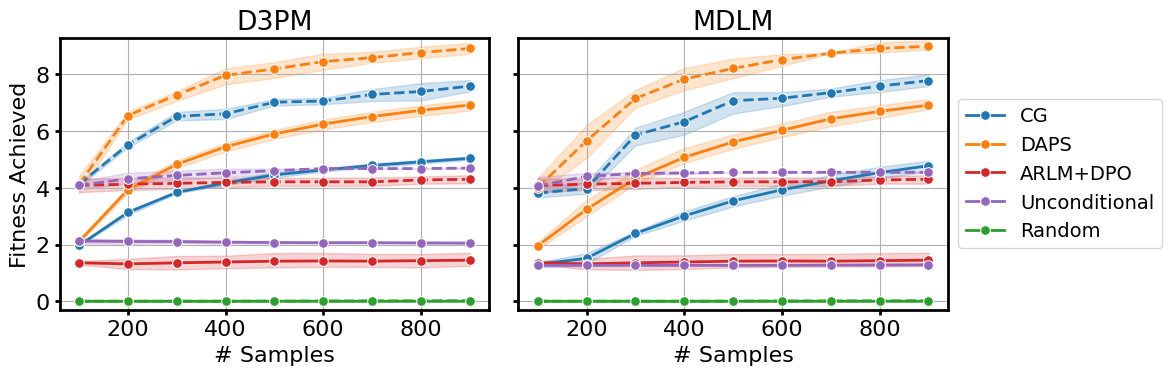

In [6]:
def get_achieved_fitness(max_df, mean_df):
    max_fitnesses = []
    mean_fitnesses = []
    for idx, row in max_df.iterrows():
        #get all rows with the same method and repeat and smaller round
        subset_df = max_df[(max_df["method"] == row["method"]) & (max_df["repeat"] == row["repeat"]) & (max_df["round"] <= row["round"])]
        #get the max fitness value
        max_fitness = subset_df["fitness"].max()
        max_fitnesses.append(max_fitness)

        #works if there is an equal number of samples per round
        subset_df = mean_df[(mean_df["method"] == row["method"]) & (mean_df["repeat"] == row["repeat"]) & (mean_df["round"] <= row["round"])]
        #get the mean fitness value
        mean_fitness = subset_df["fitness"].mean()
        mean_fitnesses.append(mean_fitness)

    max_df["max_achieved_fitness"] = max_fitnesses
    mean_df["mean_achieved_fitness"] = mean_fitnesses
    return max_df, mean_df

plt.figure(figsize=[12,7])
counter = 0
n_rounds = 8
num_samples = 100 #number of samples per round
# proteins = ["CreiLOV"]
# tasks = ["", "unconstrained"] 

algo = "iterative_BO" #"alignment_1000" #"iterative" "iterative_long"
proteins = ["GB1"]
tasks = ["unconstrained"] #["", "unconstrained"]
#colors= ["tab:red", "tab:purple"]
# colors = sns.color_palette("tab10")
colors = ["tab:blue", "tab:orange", "tab:red", "tab:purple", "tab:green"]

for i, protein in enumerate(proteins): 
    for j, task in enumerate(tasks):
        if 'TrpB' in protein:
            sites = [183, 184, 227, 228]
            full_seq = "MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLRDYAGRPTPLYFARRLSEKYGARVYLKREDLLHTGAHKINNAIGQVLLAKLMGKTRIIAETGAGQHGVATATAAALFGMECVIYMGEEDTIRQKLNVERMKLLGAKVVPVKSGSRTLKDAIDEALRDWITNLQTTYYVFGSVVGPHPYPIIVRNFQKVIGEETKKQIPEKEGRLPDYIVACVSGGSNAAGIFYPFIDSGVKLIGVEAGGEGLETGKHAASLLKGKIGYLHGSKTFVLQDDWGQVQVSHSVSAGLDYSGVGPEHAYWRETGKVLYDAVTDEEALDAFIELSRLEGIIPALESSHALAYLKKINIKGKVVVVNLSGRGDKDLESVLNHPYVRERIR"
        elif protein == 'CreiLOV':
            full_seq = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
            sites = [29, 34, 47, 60, 61] #7, 29, 47 have multiple types of beneficial mutations whereas 5 and 60 have two choice but high fitness
        elif protein == "GB1":
            full_seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
            sites = [39, 40, 41, 54]

        if "noUQ" in algo:
            methods = ["cls_guidance", "DAPS"]
            models = ["mdlm"]
        else:
            #methods = ["cls_guidance", "cls_guidance", "DAPS"]
            #models = ["continuous", "d3pm_finetune", "d3pm_finetune"]
            methods = ["cls_guidance", "DAPS"] #"cls_guidance"
            models = ["d3pm_finetune", "mdlm"] #"mdlm"

        for k, model in enumerate(models):
            all_dfs = []
            random_df = pd.read_csv(f"exps/protein/{protein}/baseline/summary.csv")
            random_df = random_df[random_df["method"] == "random"]
            random_df["method"] = "Random"
            all_dfs.append(random_df)

            prior_df = pd.read_csv(f"exps/protein/{protein}/{model}/prior_sample/summary.csv")
            prior_df["method"] = "Unconditional"
            all_dfs.append(prior_df)

            dpo_df = pd.read_csv(f"exps/protein/{protein}/causalLM_finetune/iterative_BO/DPO/BO_summary.csv")
            dpo_df["method"] = "ARLM+DPO"
            all_dfs.append(dpo_df)

            for method in methods:
                # if task == "unconstrained":
                #     method = method + "_unconstrained"

                df = pd.read_csv(f"exps/protein/{protein}/{model}/{algo}/{method}/BO_summary.csv")
                # random_df["repeat"] = 1
                # df["repeat"] = df["repeat"].astype(int)

                # if "unconstrained" in task:
                #     df = df[df["task"] == "unconstrained"]
                #     random_df = random_df[random_df["task"] == "unconstrained"]
                # else:
                #     df = df[df["task"] == "constrained"]
                #     random_df = random_df[random_df["task"] == "constrained"]

                # df = pd.concat([df, random_df])
                method_dict= {"cls_guidance": "CG", "DAPS": "DAPS", "DPO": "DPO", "random": "Random", "cls_guidance_unconstrained": "CLS Guidance", "DAPS_unconstrained": "DAPS", "DPO_unconstrained": "DPO"}
                model_dict = {"continuous": "Continuous", "d3pm_finetune": "D3PM", "causalLM_finetune": "LM", "mdlm": "MDLM"}

                name = method_dict[method] #model_dict[model] + " +\n"
                df["method"] = name
                #round negative fitness to zero
                all_dfs.append(df)

            all_df = pd.concat(all_dfs)
            all_df["fitness"] = all_df["fitness"].clip(lower=0) #for TrpB, round up negative predicted values to 0
            all_df["round"] = all_df["round"]*num_samples + 100
            counter += 1

            plt.subplot(2, 2, counter)

            legend = True if counter == 2 else False
            #plot round=random as solid line horizontal line
            all_df = all_df.sort_values(by=["method", "round"])
            #random_df = all_df[all_df["round"] == "random"]
            #all_df = all_df[all_df["round"] != "random"]

            #only take the max fitness from each round and method
            max_df = all_df.groupby(["method", "round", "repeat"])["fitness"].max().reset_index()
            mean_df = all_df.groupby(["method", "round", "repeat"])["fitness"].mean().reset_index()
            #get the max/mean fitness achieved by or before each round
            max_df, mean_df = get_achieved_fitness(max_df, mean_df)

            # initial_df = all_df[all_df["round"] == 0]
            # all_df = all_df[all_df["round"] != 0]
            # max_df = max_df[max_df["round"] != 0]
            # mean_df = mean_df[mean_df["round"] != 0]

            # initial_df_mean = initial_df.groupby(["method", "repeat"])["fitness"].mean().reset_index()
            # for i, (method, color) in enumerate(zip(initial_df_mean["method"].unique(), colors)):
            #     plt.hlines(initial_df_mean[initial_df_mean["method"] == method]["fitness"].mean(), 0, 10, color=color, linestyle='-')
            sns.lineplot(mean_df, y="mean_achieved_fitness", x="round", hue='method', palette=colors, legend=legend, markersize=7, hue_order=["CG", "DAPS", "ARLM+DPO", "Unconditional",  "Random"], marker='o') #dodge=0.3

            #put cls_guidance first
            # initial_df_max = initial_df.groupby(["method", "repeat"])["fitness"].max().reset_index()
            # for i, (method, color) in enumerate(zip(initial_df_max["method"].unique(), colors)):
            #     plt.hlines(initial_df_max[initial_df_max["method"] == method]["fitness"].mean(), 0, 10, color=color, linestyle='--')
            
            sns.lineplot(max_df, y="max_achieved_fitness", x="round", hue='method', ls="--", palette=colors , markersize=7, legend=False, hue_order=["CG", "DAPS","ARLM+DPO","Unconditional",  "Random"], marker='o')

            # random_maxes = []
            # random_means = []
            # x = np.arange(1, n_rounds+1)
            # for i in range(n_rounds):
            #     subset_df = random_df[:num_samples*(i+1)]
            #     random_maxes.append(subset_df["fitness"].max())
            #     random_means.append(subset_df["fitness"].mean())
            # plt.plot(x, random_maxes, color="k", linestyle="--", label="Random")
            # plt.plot(x, random_means, color="k", linestyle="-", label="Random")

            #plt.hlines(random_df["fitness"].mean(), 0, 10, color="k", linestyle=(0, (1, 1)))
            #plt.hlines(random_df["fitness"].mean(), 0, 10, color="k", linestyle='-')
            #plt.hlines(random_df["fitness"].max(), 0, 10, color="k", linestyle='--')

            if legend:
                #put legend off to the side off the plot
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
                #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                
            #move legend outside
            if counter<=1:
                #plt.gca().axes.xaxis.set_ticklabels([])
                #plt.xlabel("")
                pass

            if i == 0:
                plt.title(f"{model_dict[model]}")
                if protein != "GB1":
                    plt.xlabel("")
                    plt.gca().set_xticklabels([])
            else:
                plt.xlabel("# Samples")
            
            if protein == "TrpB":
                plt.ylim(-0.1, 1.7)
            elif protein == "CreiLOV":
                plt.ylim(1.6, 5.8)
            elif protein == "GB1":
                plt.ylim(-0.3, 9.3)
                plt.xlabel("# Samples")
            
            if k == 0:
                plt.ylabel("Fitness Achieved")
            else:
                plt.ylabel("")
                plt.gca().set_yticklabels([])
            #     if counter == 1:
            #         plt.title("max 4 mutations")
            #     else:
            #         plt.title("unconstrained")

            #plt.ylabel("")
            # if counter in [2,4]:
            #     plt.ylabel("")
            # else:
            #     plt.ylabel(protein + " Fitness")
            plt.grid()

    plt.tight_layout()
    #plt.savefig(f"figures/{algo}.svg")

In [15]:
def get_achieved_fitness(max_df, mean_df, protein):
    max_fitnesses = []
    mean_fitnesses = []
    max_df = max_df[max_df["protein"] == protein]
    mean_df = mean_df[mean_df["protein"] == protein]
    for idx, row in max_df.iterrows():
        #get all rows with the same method and repeat and smaller round
        subset_df = max_df[(max_df["algo"] == row["algo"]) & (max_df["method"] == row["method"]) & (max_df["repeat"] == row["repeat"]) & (max_df["round"] <= row["round"])]
        #get the max fitness value
        max_fitness = subset_df["fitness"].max()
        max_fitnesses.append(max_fitness)

        #works if there is an equal number of samples per round
        subset_df = mean_df[(max_df["algo"] == row["algo"]) & (mean_df["method"] == row["method"]) & (mean_df["repeat"] == row["repeat"]) & (mean_df["round"] <= row["round"])]
        #get the mean fitness value
        mean_fitness = subset_df["fitness"].mean()
        mean_fitnesses.append(mean_fitness)

    max_df["max_achieved_fitness"] = max_fitnesses
    mean_df["mean_achieved_fitness"] = mean_fitnesses
    return max_df, mean_df

proteins = ["TrpB", "CreiLOV"]
algos = ["iterative_BO_noUQ", "iterative_BO"]
methods = ["cls_guidance", "DAPS"]
models = ["d3pm_finetune", "mdlm"]
diversity_metric = shannon_entropy #"nunique" #shannon_entropy #"nunique"
algo_dict = {"iterative_BO_noUQ": "Single Model", "iterative_BO": "Ensemble"}

sites = [117, 118, 119, 162, 166, 182, 183, 184, 185, 186, 227, 228, 230, 231, 301]
all_dfs = []
for protein in proteins:
    for algo in algos:
        for method in methods:
            for model in models:
                df = pd.read_csv(f"exps/protein/{protein}/{model}/{algo}/{method}/BO_summary.csv")
                if protein == "TrpB":
                    df["sequence"] = df["sequence"].apply(lambda x: "".join([x[i-1] for i in sites]))
                df["protein"] = protein
                df["model"] = model
                df["algo"] = algo_dict[algo]
                df["method"] = method_dict[method]
                all_dfs.append(df)
    all_df = pd.concat(all_dfs)
    
diversity_df = all_df.groupby(["protein", "model", "method", "round", "algo", "repeat"]).agg({"sequence": diversity_metric}).reset_index()
diversity_df.rename(columns={"sequence": "diversity"}, inplace=True)
max_df = all_df.groupby(["protein", "model", "method", "round", "algo", "repeat"])["fitness"].max().reset_index()
mean_df = all_df.groupby(["protein", "model", "method", "round", "algo", "repeat"])["fitness"].mean().reset_index()

/tmp/ipykernel_3978623/778961113.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.lineplot(subset_df, y="diversity", x="round", hue='method', style="algo", palette=colors, legend=legend, markersize=7, marker='o', hue_order=["CG", "DAPS"], style_order=["Ensemble", "Single Model"])
/tmp/ipykernel_3978623/778961113.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.lineplot(subset_df, y="diversity", x="round", hue='method', style="algo", palette=colors, legend=legend, markersize=7, marker='o', hue_order=["CG", "DAPS"], style_order=["Ensemble", "Single Model"])
/tmp/ipykernel_3978623/778961113.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.lineplot(subset_df, y="diversity", x="round", hue='method', style="algo", palette=colors, legend=legend, markersize=7, marker='o', hue_order=["CG", "DAPS"], style_order=["Ensemble", 

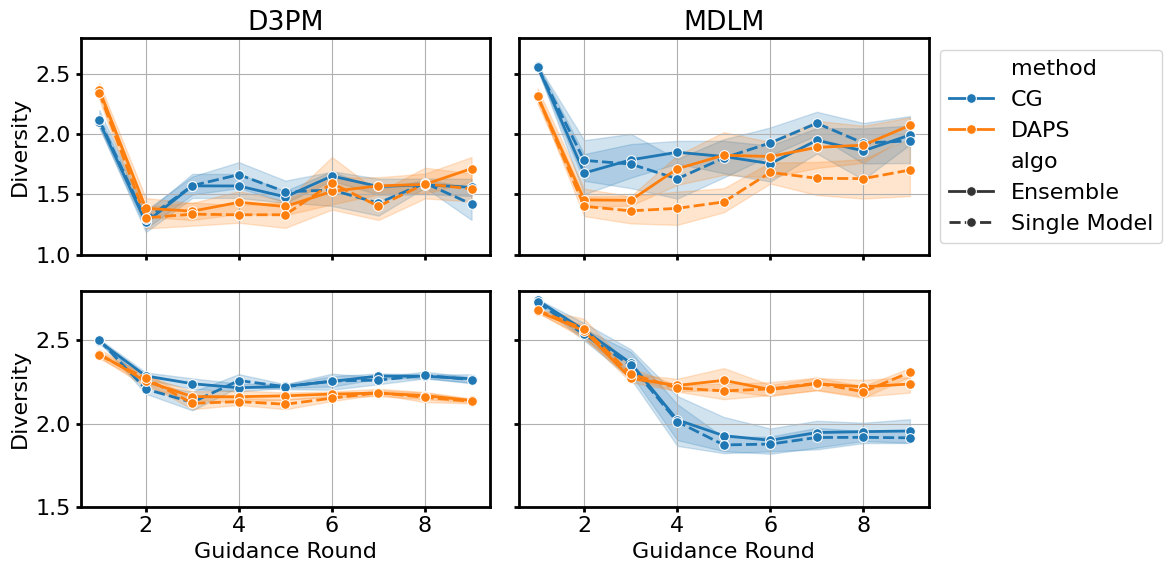

In [16]:
plt.figure(figsize=(12, 6))

for j, protein in enumerate(proteins):
    for i, model in enumerate(models):
        plt.subplot(2, 2, 2*j + i+1)
        legend = True if j == 0 and i == 1 else False

        subset_df = diversity_df[diversity_df["protein"] == protein]
        subset_df = subset_df[subset_df["model"] == model]
        subset_df["round"] = subset_df["round"] + 1
        #subset_df["round"] = subset_df["round"]*num_samples + 100
        sns.lineplot(subset_df, y="diversity", x="round", hue='method', style="algo", palette=colors, legend=legend, markersize=7, marker='o', hue_order=["CG", "DAPS"], style_order=["Ensemble", "Single Model"]) 
        
        plt.ylim(1.5, 2.8)
        plt.xlabel("Guidance Round")         
        plt.ylabel("Diversity")

        if j == 0:
            plt.title(f"{model_dict[model]}")
            plt.xlabel("")
            plt.gca().set_xticklabels([])
            plt.ylim(1.0, 2.8)

        if i == 1:
            plt.ylabel("")
            plt.gca().set_yticklabels([])
        plt.grid()
        #place legend to the side on the right
        if legend:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f"figures/diversity_ensemble.svg")

In [24]:
protein = "TrpB"
max_TrpB_df, mean_TrpB_df = get_achieved_fitness(max_df, mean_df, protein)
max_TrpB_df = max_TrpB_df.groupby(["protein", "model", "method", "round", "algo"])["max_achieved_fitness"].mean().reset_index()
mean_TrpB_df = mean_TrpB_df.groupby(["protein", "model", "method", "round", "algo"])["mean_achieved_fitness"].mean().reset_index()

protein = "CreiLOV"
max_CreiLOV_df, mean_CreiLOV_df = get_achieved_fitness(max_df, mean_df, protein)
max_CreiLOV_df = max_CreiLOV_df.groupby(["protein", "model", "method", "round", "algo"])["max_achieved_fitness"].mean().reset_index()
mean_CreiLOV_df = mean_CreiLOV_df.groupby(["protein", "model", "method", "round", "algo"])["mean_achieved_fitness"].mean().reset_index()
all_max_df = pd.concat([max_TrpB_df, max_CreiLOV_df])

/tmp/ipykernel_3978623/575046369.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_df["max_achieved_fitness"] = max_fitnesses
/tmp/ipykernel_3978623/575046369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_df["mean_achieved_fitness"] = mean_fitnesses
/tmp/ipykernel_3978623/575046369.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [28]:
final_df = all_max_df[all_max_df["round"] == 8]
#pivot on protein and algo into columns
final_df = final_df.pivot(index=["protein", "model", "method", "round"], columns=["algo"], values="max_achieved_fitness").reset_index()
final_df

algo,protein,model,method,round,Ensemble,Single Model
0,CreiLOV,d3pm_finetune,CG,8.0,5.608433,5.552426
1,CreiLOV,d3pm_finetune,DAPS,8.0,5.522398,5.520497
2,CreiLOV,mdlm,CG,8.0,5.608433,5.552426
3,CreiLOV,mdlm,DAPS,8.0,5.529864,5.520497
4,TrpB,d3pm_finetune,CG,8.0,1.551081,1.542701
5,TrpB,d3pm_finetune,DAPS,8.0,1.594964,1.568168
6,TrpB,mdlm,CG,8.0,1.551081,1.542701
7,TrpB,mdlm,DAPS,8.0,1.594964,1.568168


### Random other code

In [21]:
from scipy.stats import ttest_ind
#compare creilov cls_guidance, prior and aligned
#creilov_df = all_df[all_df["protein"] == "CreiLOV"]
for method in ["DPO_noinpaint", "cls_guidance_noinpaint"]:
    cls_guidance = all_df[all_df["method"] == method]
    prior = cls_guidance[cls_guidance["round"] == "prior"]
    aligned = cls_guidance[cls_guidance["round"] == "aligned"]
    print(ttest_ind(prior["fitness"], aligned["fitness"]))

TtestResult(statistic=-6.0871022663032095, pvalue=1.3747870120068056e-09, df=1998.0)
TtestResult(statistic=-10.312355932512952, pvalue=2.9493593998465645e-22, df=398.0)


In [12]:
import numpy as np
np.mean(prior["fitness"]), np.mean(aligned["fitness"])

(4.0123010474443435, 4.014682020726204)

In [9]:
len(prior[prior["fitness"] > 4]) / len(prior)

0.6533

In [10]:
#get fraction of prior > 4.1
len(aligned[aligned["fitness"] > 4]) / len(aligned)

0.6663

In [22]:
full_seq = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"

In [25]:
df = pd.read_csv(f"exps/protein/CreiLOV/d3pm_finetune/CreiLOV/iterative/cls_guidance/summary.csv")
df["n_mutations"] = df["sequence"].apply(lambda x: get_n_mutations(x, full_seq))
df["mut"] = df["sequence"].apply(lambda x: get_mutations(x, full_seq))
df.sort_values("fitness", ascending=False)

#find where the sequence is different from the full_seq

,sequence,round,fitness,n_mutations,mut
1110,MAGLRHSFVVADATLKDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,1,4.197413,3,"[7S, 16K, 114T]"
1029,MAGLRHSFVVADATLLDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,1,4.179452,3,"[7S, 16L, 114Q]"
1101,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,1,4.164648,2,"[7S, 114Q]"
1053,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,1,4.161065,2,"[7S, 114R]"
651,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,4.153726,4,"[72E, 74V, 105I, 115A]"
...,...,...,...,...,...
440,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNCRDL...,0,3.645479,3,"[43C, 45D, 106H]"
397,MAGLRHTFVVADITLPDCPLVYASEGFYAMTGYGPDEVLGHNCRDL...,0,3.623625,4,"[13I, 43C, 45D, 106M]"
994,MAGLRHTFVVADATLPDCPCVYASEGFYAMTGYGPDEVLGHNARFL...,0,3.618612,3,"[20C, 48P, 83R]"
974,MAGLRHTFVVADATLPDCPYVYASEGFYAMTGYGPDEVLGHNARFL...,0,3.587917,3,"[20Y, 48H, 83C]"
